# Profiling of `maze_dataset` serializing/loading/saving/reading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter
from muutils.timeit_fancy import timeit_fancy, FancyTimeitResult

from maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
    set_serialize_minimal_threshold,
)
from maze_dataset.generation.generators import GENERATORS_MAP

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
        name="test",
        grid_n=grid_n,
        n_mazes=n_mazes,
        maze_ctor=GENERATORS_MAP["gen_dfs"],
    )
    for grid_n, n_mazes in itertools.product(
        [10],
        np.logspace(1, 2, 2, dtype=int).tolist(),  # 100, for CI tests
        # np.logspace(1, 3, 5, dtype=int).tolist(), # 1k
        # np.logspace(0, 4, 9, dtype=int).tolist(), # 10k, notebook results from this set
    )
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg, load_local=False) for cfg in cfgs]

## Profile

In [3]:
columns: list[str] = [
    "grid_n",
    "n_mazes",
    "serialize",
    "serialize_minimal",
    "load",
    "load_minimal",
    "save",
    "save_minimal",
    "read",
    "read_minimal",
]
speeds_data: list[dict] = list()

In [4]:
def wrapped_timeit_fancy(
    name: str,
    function: Callable,
    do_profiling: bool,
    repeats: int,
    timing_stat: Callable[[StatCounter], float],
) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value


def measure_dataset_speed(
    d: MazeDataset,
    do_profiling: bool = True,
    repeats: int = 1,
    timing_stat: Callable[[StatCounter], float] = StatCounter.min,
) -> dict:
    if repeats > 1:
        warnings.warn(
            "Repeats > 1, results might not be accurate due to generation metadata being collected."
        )
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    set_serialize_minimal_threshold(None)
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        "serialize_full", _d_cpy._serialize_full, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        "serialize_minimal", _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    # info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
    #     'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    # )
    # row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)
    info_serialize_cat, result_serialize_cat = wrapped_timeit_fancy(
        "serialize_minimal_soln_cat",
        _d_cpy._serialize_minimal_soln_cat,
        **kwargs_fancy_timeit,
    )
    row_data.update(info_serialize_cat)
    _d_cpy = copy.deepcopy(d)

    row_data.update(
        wrapped_timeit_fancy(
            "load_full",
            lambda: MazeDataset._load_full(result_serialize),
            **kwargs_fancy_timeit,
        )[0]
    )
    row_data.update(
        wrapped_timeit_fancy(
            "load_minimal",
            lambda: MazeDataset._load_minimal(result_serialize_min),
            **kwargs_fancy_timeit,
        )[0]
    )
    row_data.update(
        wrapped_timeit_fancy(
            "load_minimal_soln_cat",
            lambda: MazeDataset._load_minimal_soln_cat(result_serialize_cat),
            **kwargs_fancy_timeit,
        )[0]
    )

    # saving and loading
    path_default: str = f"../data/{d.cfg.to_fname()}.zanj"
    path_min: str = f"../data/{d.cfg.to_fname()}_min.zanj"

    # default
    set_serialize_minimal_threshold(None)
    _d_cpy = copy.deepcopy(d)
    row_data.update(
        wrapped_timeit_fancy(
            "save", lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
        )[0]
    )
    _d_cpy = copy.deepcopy(d)

    row_data.update(
        wrapped_timeit_fancy(
            "read",
            lambda: MazeDataset.read(file_path=path_default),
            **kwargs_fancy_timeit,
        )[0]
    )

    # minimal
    set_serialize_minimal_threshold(0)
    _d_cpy = copy.deepcopy(d)
    row_data.update(
        wrapped_timeit_fancy(
            "save_minimal",
            lambda: _d_cpy.save(file_path=path_min),
            **kwargs_fancy_timeit,
        )[0]
    )
    _d_cpy = copy.deepcopy(d)

    row_data.update(
        wrapped_timeit_fancy(
            "read_minimal",
            lambda: MazeDataset.read(file_path=path_min),
            **kwargs_fancy_timeit,
        )[0]
    )

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    set_serialize_minimal_threshold(None)

    return row_data

## Profile small datasets only

In [5]:
for i, d in enumerate(datasets):
    print(f"Profiling {i+1}/{len(datasets)}:\t{d.cfg}")
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k: v for k, v in result.items() if ":" not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/2:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001A350E0FF60>, maze_ctor_kwargs={}, endpoint_kwargs={})
	{'grid_n': 10, 'n_mazes': 10, 'serialize_full': 0.007115100044757128, 'serialize_minimal': 0.011018999968655407, 'serialize_minimal_soln_cat': 0.01693159993737936, 'load_full': 0.04067289992235601, 'load_minimal': 0.005830800044350326, 'load_minimal_soln_cat': 0.011810699943453074, 'save': 0.15868799993768334, 'read': 0.05973360000643879, 'save_minimal': 0.058346400037407875, 'read_minimal': 0.04472080001141876}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=10, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x000001A350E0FF60>, maze_ctor_kwargs={}, endpoint_kwargs={})
Profiling 2/2:	MazeDatasetConfig(name='test', 

### Results

In [6]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

SPEEDS

,grid_n,n_mazes,serialize_full,serialize_full:stats,serialize_full:profiling,serialize_minimal,serialize_minimal:stats,serialize_minimal:profiling,serialize_minimal_soln_cat,serialize_minimal_soln_cat:stats,...,save:profiling,read,read:stats,read:profiling,save_minimal,save_minimal:stats,save_minimal:profiling,read_minimal,read_minimal:stats,read_minimal:profiling
0,10,10,0.007115,{0.007115100044757128: 1},<pstats.Stats object at 0x000001A350FCFE10>,0.011019,{0.011018999968655407: 1},<pstats.Stats object at 0x000001A350FB3E10>,0.016932,{0.01693159993737936: 1},...,<pstats.Stats object at 0x000001A34F82BE90>,0.059734,{0.05973360000643879: 1},<pstats.Stats object at 0x000001A3508BC1D0>,0.058346,{0.058346400037407875: 1},<pstats.Stats object at 0x000001A34F756BD0>,0.044721,{0.04472080001141876: 1},<pstats.Stats object at 0x000001A3510CF7D0>
1,10,100,0.006408,{0.006408300017938018: 1},<pstats.Stats object at 0x000001A350FC6A50>,0.004240,{0.004239900037646294: 1},<pstats.Stats object at 0x000001A350F0AED0>,0.006231,{0.006230699946172535: 1},...,<pstats.Stats object at 0x000001A34F87B190>,0.035758,{0.03575809998437762: 1},<pstats.Stats object at 0x000001A351234850>,0.032916,{0.03291569999419153: 1},<pstats.Stats object at 0x000001A35133D750>,0.017508,{0.01750840002205223: 1},<pstats.Stats object at 0x000001A350F71910>


In [7]:
def compute_speedups(speeds: pd.DataFrame) -> pd.DataFrame:
    # for prefix in column_measurement_prefixes:
    #     speeds[f'{prefix}_speedup'] = speeds[f'{prefix}_full'] / speeds[f'{prefix}_minimal']
    speeds["serialize/speedup"] = speeds["serialize_full"] / speeds["serialize_minimal"]
    speeds["load/speedup"] = speeds["load_full"] / speeds["load_minimal"]
    speeds["save/speedup"] = speeds["save"] / speeds["save_minimal"]
    speeds["read/speedup"] = speeds["read"] / speeds["read_minimal"]

    return speeds


SPEEDS = compute_speedups(SPEEDS)

In [8]:
SPEEDS[[c for c in SPEEDS.columns if ":" not in c]]

,grid_n,n_mazes,serialize_full,serialize_minimal,serialize_minimal_soln_cat,load_full,load_minimal,load_minimal_soln_cat,save,read,save_minimal,read_minimal,serialize/speedup,load/speedup,save/speedup,read/speedup
0,10,10,0.007115,0.011019,0.016932,0.040673,0.005831,0.011811,0.158688,0.059734,0.058346,0.044721,0.645712,6.975526,2.719756,1.335701
1,10,100,0.006408,0.004240,0.006231,0.021007,0.004550,0.014801,0.432701,0.035758,0.032916,0.017508,1.511427,4.617250,13.145727,2.042340


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


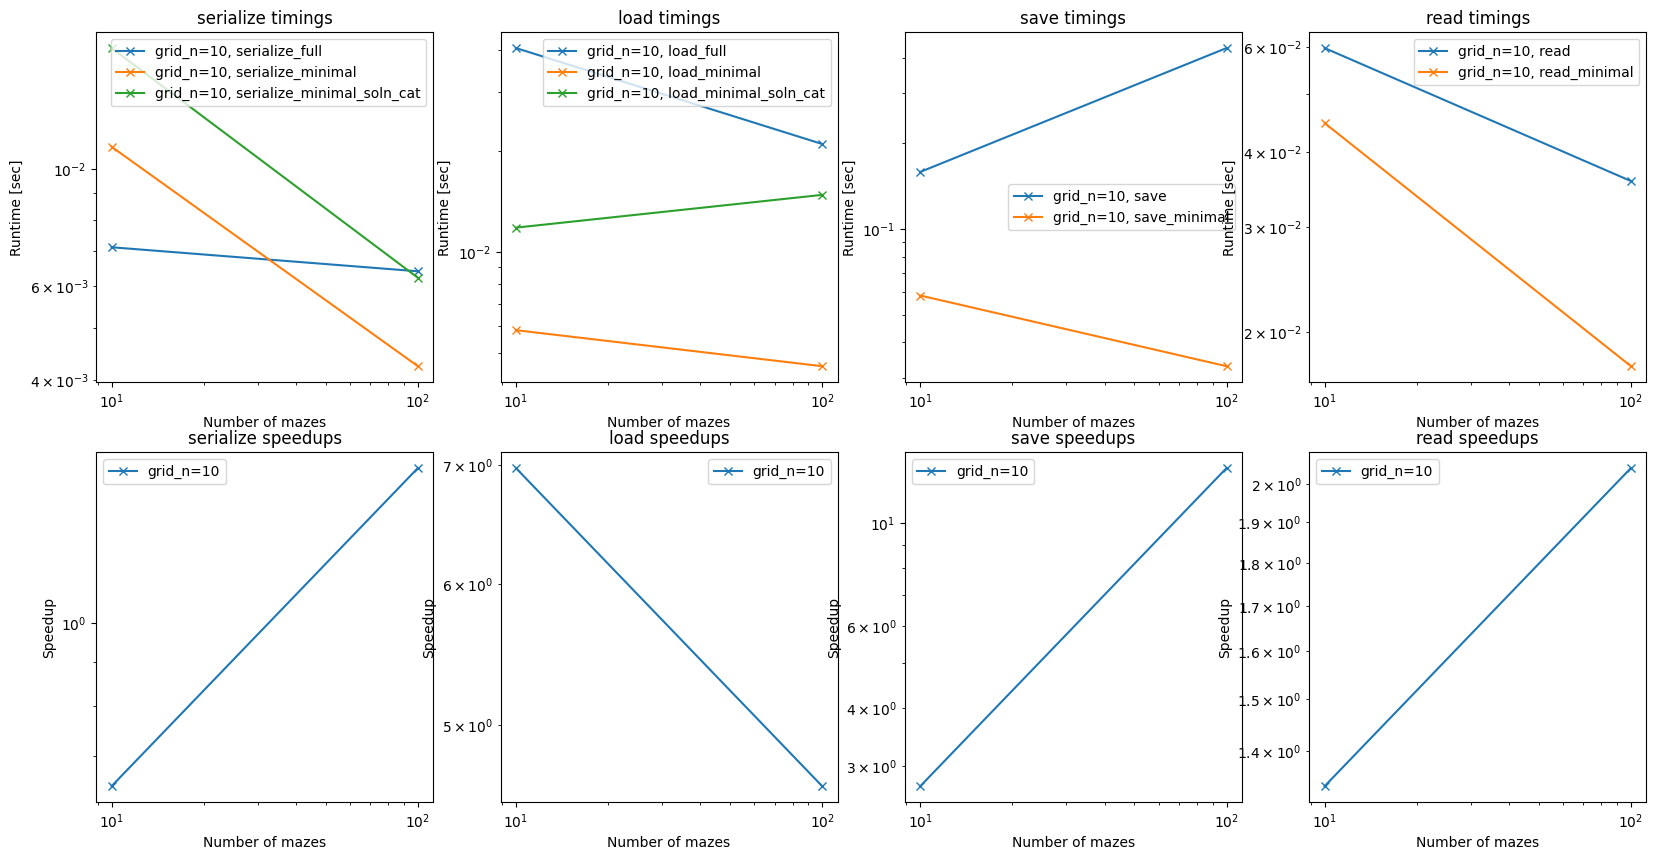

In [9]:
def plot_speeds(
    speeds: pd.DataFrame,
    column_measurement_prefixes: list[str] = ["serialize", "load", "save", "read"],
) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements * 5, 10))

    unique_grid_ns: list[int] = speeds["grid_n"].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f"Plotting {prefix} timings and speedups")
        for grid_n in unique_grid_ns:
            print(f"Plotting grid_n={grid_n}")
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds["grid_n"] == grid_n].sort_values("n_mazes")
            x_n_mazes = speeds_masked["n_mazes"]

            # Plotting
            for col in speeds_masked.columns:
                if (prefix in col) and ("speedup" not in col) and (":" not in col):
                    ax_timings.plot(
                        x_n_mazes,
                        speeds_masked[col],
                        "x-",
                        label=f"grid_n={grid_n}, {col}",
                    )

            # Setting multiple properties with `set`
            ax_timings.set(
                xscale="log",
                yscale="log",
                xlabel="Number of mazes",
                ylabel="Runtime [sec]",
                title=f"{prefix} timings",
            )
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(
                x_n_mazes,
                speeds_masked[f"{prefix}/speedup"],
                "x-",
                label=f"grid_n={grid_n}",
            )

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(
                xscale="log",
                yscale="log",
                xlabel="Number of mazes",
                ylabel="Speedup",
                title=f"{prefix} speedups",
            )
            ax_speedups.legend()


plot_speeds(SPEEDS)

Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [10]:
SPEEDS[["grid_n", "n_mazes", "serialize_minimal_soln_cat:profiling"]]

,grid_n,n_mazes,serialize_minimal_soln_cat:profiling
0,10,10,<pstats.Stats object at 0x000001A330811F90>
1,10,100,<pstats.Stats object at 0x000001A350FCFDD0>


In [11]:
SPEEDS["serialize_minimal_soln_cat:profiling"][len(SPEEDS) - 1].sort_stats(
    "tottime"
).print_stats()

         6060 function calls (5858 primitive calls) in 0.014 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      724    0.005    0.000    0.009    0.000 tokenize.py:433(_tokenize)
      671    0.002    0.000    0.002    0.000 {method 'match' of 're.Pattern' objects}
        1    0.001    0.001    0.011    0.011 inspect.py:1224(getblock)
      723    0.001    0.000    0.001    0.000 inspect.py:1181(tokeneater)
        1    0.001    0.001    0.014    0.014 maze_dataset.py:454(_serialize_minimal_soln_cat)
      723    0.001    0.000    0.001    0.000 <string>:1(<lambda>)
    172/2    0.000    0.000    0.013    0.006 json_serialize.py:271(json_serialize)
      723    0.000    0.000    0.000    0.000 {built-in method __new__ of type object at 0x00007FFA82EE8F90}
      8/1    0.000    0.000    0.001    0.001 json_serialize.py:112(<dictcomp>)
      101    0.000    0.000    0.000    0.000 {built-in method numpy.array}
      647  